In [1]:
try:
  %tensorflow_veriosn 2.0
except Exception:
 pass

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
  
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

print(f'training pairs shape {tr_pairs.shape}')
print(f'training label shape {tr_y.shape}')

4423680/4422102 [==============================] - 0s 0us/step
training pairs shape (119980, 2, 28, 28)
training label shape (119980,)


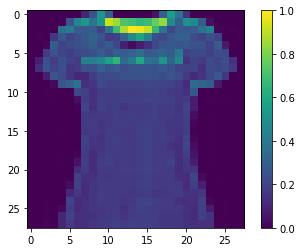

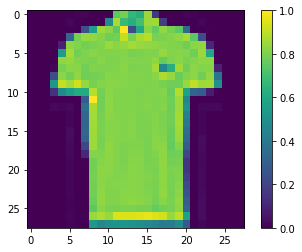

1.0


In [5]:
pair_index = 8

show_image(ts_pairs[pair_index][0])
show_image(ts_pairs[pair_index][1])

print(tr_y[pair_index])

In [6]:
def initialize_base_network():
  input = Input(shape=(28, 28), name='base_input')

  x = Flatten(name='flatten_input')(input)
  x = Dense(128, activation='relu', name='first_base_dense')(x)
  x = Dropout(0.1, name='first_base_dropout')(x)
  x = Dense(128, activation='relu', name='second_base_dense')(x)
  x = Dropout(0.1, name='second_base_dropout')(x)
  x = Dense(128, activation='relu', name='third_base_dense')(x)

  model = Model(inputs=input, outputs=x)
  return model

def euclidean_distance(vects):
  v1, v2 = vects
  sum_square = K.sum(K.square(v1-v2), axis=1, keepdims=True)
  distance = K.sqrt(K.maximum(sum_square, K.epsilon()))
  return distance

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

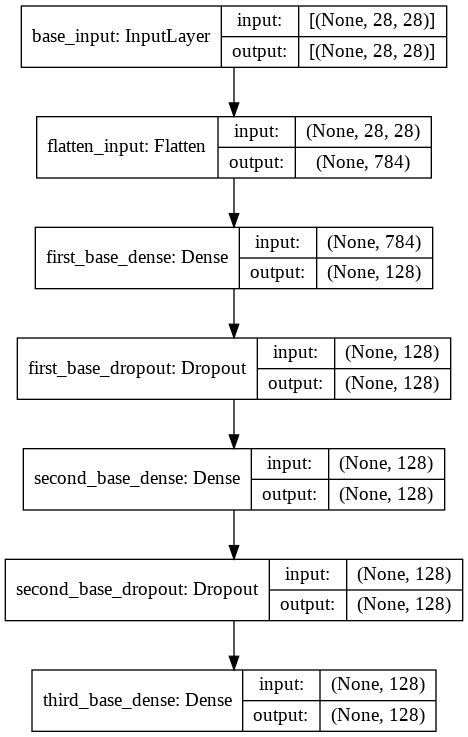

In [7]:
base_model = initialize_base_network()
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

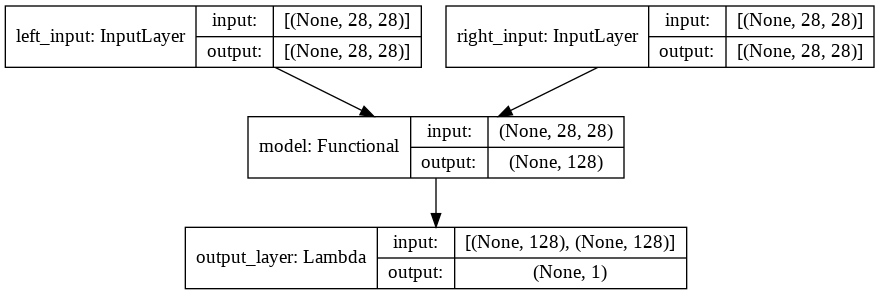

In [10]:
left_input = Input(shape=(28, 28), name='left_input')
right_input = Input(shape=(28, 28), name='right_input')

left_vect = base_model(left_input)
right_vect = base_model(right_input)

#output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([left_vect, right_vect])
output = Lambda(euclidean_distance, name="output_layer")([left_vect, right_vect])

model = Model(inputs=[left_input, right_input], outputs=output)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [11]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [12]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, 
                    epochs=20, 
                    batch_size=128, 
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 9ms/step - loss: 0.1485 - val_loss: 0.0890
Epoch 2/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0826 - val_loss: 0.0772
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0725 - val_loss: 0.0746
Epoch 4/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0666 - val_loss: 0.0685
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0639 - val_loss: 0.0687
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0630 - val_loss: 0.0668
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0602 - val_loss: 0.0699
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0597 - val_loss: 0.0651
Epoch 9/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0579 - val_loss: 0.0629
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0568 - val_loss: 0.0649

In [13]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [14]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step - loss: 0.0628
Loss = 0.06279614567756653, Train Accuracy = 0.06171861976996166 Test Accuracy = 0.08293293293293293


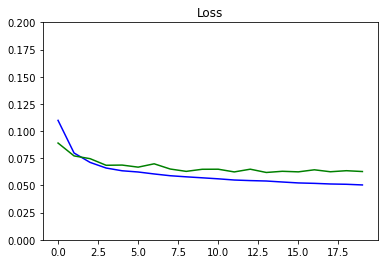

In [15]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [16]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

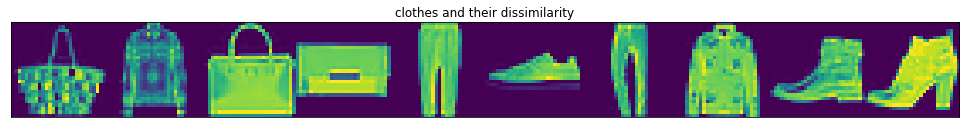

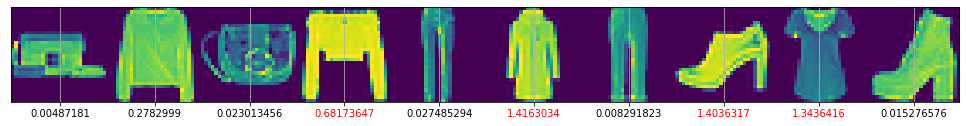

In [17]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[indexes, 0], tr_pairs[indexes, 1], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)